# Examine Clusters

In [1]:
import os
from decouple import config
import second_level_functions as slf
import numpy as np
import pandas as pd
import ptitprince as pt
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

Change task and contrast to examine clusters

In [2]:
task = 'fear'
contrast = 'time'

Read in images and get parameter estimates

In [3]:
base_dir = config(task)
path = os.path.join(base_dir, '2ndlevel', 'mixed_model')
images = slf.get_images(path)
contrasts = slf.contrast_imgs(images['t_stat'], images['pvals'])
threshold_pval = -np.log10(0.05)
parameter_estimates_df = slf.get_parameter_estimates(contrasts[contrast]['pvals'], threshold_pval, path, base_dir)
parameter_estimates_df['mean'] = parameter_estimates_df.iloc[0:,4:].mean(axis=1)

## Plot and get mean of parameter estimates

Split parameter estimates by group and time point. Then get mean of each group and at in each time point

In [4]:
an_t1 = parameter_estimates_df.loc[(parameter_estimates_df['group'] == 'AN') & (parameter_estimates_df['time_point'] == 't1')]
an_t2 = parameter_estimates_df.loc[(parameter_estimates_df['group'] == 'AN') & (parameter_estimates_df['time_point'] == 't2')]
hc_t1 = parameter_estimates_df.loc[(parameter_estimates_df['group'] == 'HC') & (parameter_estimates_df['time_point'] == 't1')]
hc_t2 = parameter_estimates_df.loc[(parameter_estimates_df['group'] == 'HC') & (parameter_estimates_df['time_point'] == 't2')]

In [5]:
means_std_df = pd.DataFrame(data={
    'AN mean':  [an_t1['mean'].mean(), an_t2['mean'].mean(), pd.concat((an_t1, an_t2))['mean'].mean()],
    'HC mean': [hc_t1['mean'].mean(), hc_t2['mean'].mean(), pd.concat((hc_t1, hc_t2))['mean'].mean()],
    'AN std': [an_t1['mean'].std(), an_t2['mean'].std(), pd.concat((an_t1, an_t2))['mean'].std()],
    'HC std': [hc_t1['mean'].std(), hc_t2['mean'].std(), pd.concat((hc_t1, hc_t2))['mean'].std()]
                   }, index=['T1', 'T2', 'Overall']) 
means_std_df

,AN mean,HC mean,AN std,HC std
T1,2.245502,2.489725,0.803969,1.311278
T2,3.103312,6.447288,2.761740,7.243975
Overall,2.674407,4.468506,2.071257,5.529511


Plot parameter estimates

<AxesSubplot: xlabel='time_point', ylabel='mean'>

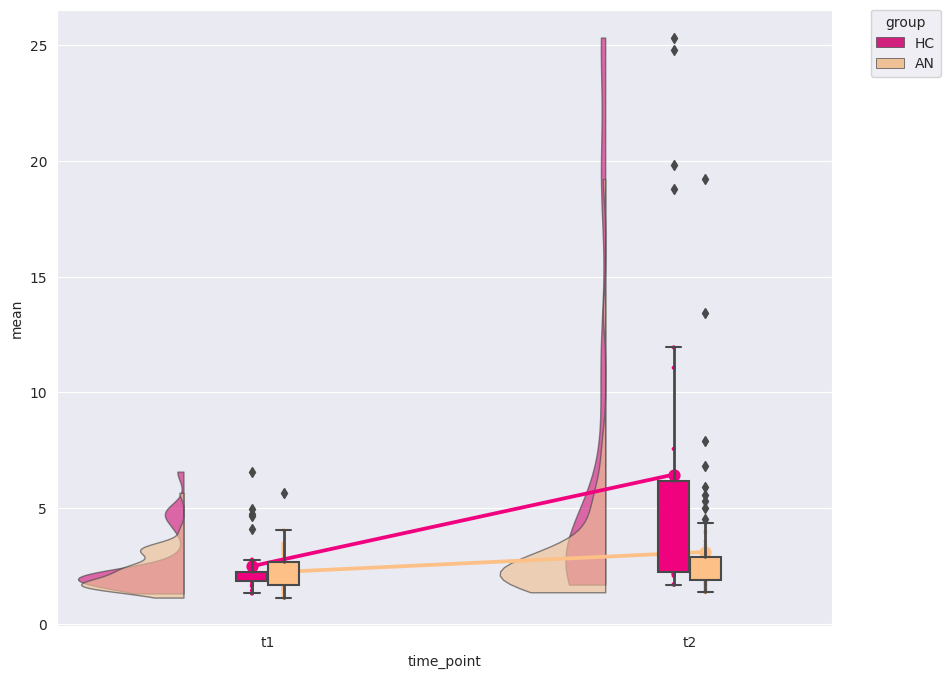

In [6]:
fig,ax = plt.subplots(1,1, figsize=(10, 8))
pt.RainCloud(
    x="time_point", 
    y="mean", 
    hue="group", 
    data=parameter_estimates_df, 
    palette='Accent_r', 
    alpha = .65, 
    dodge = True, 
    scale = "area",
    ax=ax,
    width_viol=.5,
    jitter=0,
    pointplot = True,
    bw = .3
     )



## Linear Mixed Model

Change reference level of model by changing the name of AN to participant with AN (pAN) and HC to Control

In [7]:
regression_df = parameter_estimates_df
regression_df['group'] = regression_df['group'].apply(lambda group: 'pAN' if group == 'AN' else 'Control')

define and fit the model

In [8]:
model = smf.mixedlm("mean ~ time_point + group + group*time_point", 
                    regression_df, 
                    groups=regression_df["sub"]).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                   MixedLM      Dependent Variable:      mean     
No. Observations:        184          Method:                  REML     
No. Groups:              92           Scale:                   8.9845   
Min. group size:         2            Log-Likelihood:          -475.5326
Max. group size:         2            Converged:               Yes      
Mean group size:         2.0                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      2.490    0.632  3.942 0.000  1.252  3.728
time_point[T.t2]               3.958    0.816  4.851 0.000  2.359  5.556
group[T.pAN]                  -0.244    0.751 -0.325 0.745 -1.717  1.228
group[T.pAN]:time_point[T.t2] -3.100    0.971 -3.194 0.001 -5.002 -1.198
Group Var                      1.785    0.442                           
========================================================================

"""

**Bayes comparison**

Define a null model (no group just time and subject intercepts).

Then calculate the bayes factor by dividing the log likelihood of each model

In [9]:
null = smf.mixedlm("mean ~ time_point + sub*time_point", 
                    regression_df, 
                    groups=regression_df["sub"]).fit()

In [10]:
bayes_factor = model.llf / null.llf
bayes_factor

1.002684564507335